In [1]:
import os

os.chdir("..")
print(os.getcwd())

/Users/krishgoyani/Developer/Data Ingestion and RAG


In [2]:
import os

In [9]:
os.environ["UNSTRUCTURED_API_KEY"] = "EjqLklyAmKEAtQiLz1awmSIAsKXKqT"
os.environ["UNSTRUCTURED_API_URL"] = "https://api.unstructuredapp.io/general/v0/general"

In [10]:
!pip install -U unstructured_client -q
!pip install matplotlib -q
!pip install markdownify -q

In [11]:
import os, json
from dotenv import  load_dotenv
import unstructured_client
from unstructured_client.models import shared
import certifi
import requests
import httpx
load_dotenv()
http_client = requests.Session()
http_client.verify = False

client = unstructured_client.UnstructuredClient(
    api_key_auth=os.getenv("UNSTRUCTURED_API_KEY"),
    server_url="https://api.unstructuredapp.io/general/v0/general",
    client = httpx.Client(verify=False)
    
)

In [19]:
docs = []
import nest_asyncio
nest_asyncio.apply()
import asyncio

async def call_api(filename):
    req = {
    "partition_parameters": {
        "files": {
            "content": open(filename, "rb"),
            "file_name": filename,
        },
        "strategy": shared.Strategy.HI_RES,
        "languages": ['eng'],
        "split_pdf_page": True,            # If True, splits the PDF file into smaller chunks of pages.
        "split_pdf_allow_failed": True,    # If True, the partitioning continues even if some pages fail.
        "split_pdf_concurrency_level": 15,
        "extract_image_block_types" :  ["Image", "Table"] ,
        "pdf_infer_table_structure": True # Set the number of concurrent request to the maximum value: 15.
    }
    }
    
    try:
        res = await client.general.partition_async(request=req) 
        elements_dict = [element for element in res.elements]
        docs.extend(elements_dict)
        
    except Exception as e:
        print(f"Error processing {filename}: {e}")


async def process_files(input_directory):
    tasks = []

    for root, _, files in os.walk(input_directory):
        for file in files:
            if not file.endswith('.json'):
                full_path = os.path.join(root, file)
                tasks.append(call_api(full_path))

    await asyncio.gather(*tasks)
    
    
if __name__ == "__main__":
    asyncio.run(process_files("data"))

INFO: HTTP Request: GET https://api.unstructuredapp.io/general/docs "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"


In [14]:
docs[0]

{'type': 'NarrativeText',
 'element_id': '51d7a52aad80225d8a3b8e18c6d7493f',
 'text': 'Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.',
 'metadata': {'languages': ['eng'],
  'filename': 'example_converted.md',
  'filetype': 'text/markdown'}}

In [29]:
!pip install  htmltabletomd -q

In [48]:
docs[0]

{'type': 'NarrativeText',
 'element_id': 'a0c571c56bad4d1fe5d626801b0cf353',
 'text': 'Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 1,
  'filename': 'file.pdf'}}

In [49]:
set([x['type'] for x in docs])

{'Footer',
 'Formula',
 'Image',
 'NarrativeText',
 'PageNumber',
 'Table',
 'Title',
 'UncategorizedText'}

In [ ]:
images = [x["metadata"]["image_base64"] for x in docs if x["type"] in ["Image" , "Table"]]
len(images)


10

In [37]:
import base64

# Base64 string (example)
base64_str = images[6]

# Decode Base64 to get binary image data
binary_data = base64.b64decode(base64_str)

# Calculate size in bytes
size_bytes = len(binary_data)

# Convert to KB and MB
size_kb = size_bytes / 1024
size_mb = size_kb / 1024

print(f"Size: {size_bytes} bytes")
print(f"Size: {size_kb:.2f} KB")
print(f"Size: {size_mb:.2f} MB")


Size: 94688 bytes
Size: 92.47 KB
Size: 0.09 MB


In [21]:
len(images)

203

'Attention(Q, K, V ) = softmax( QK T √ dk )V'

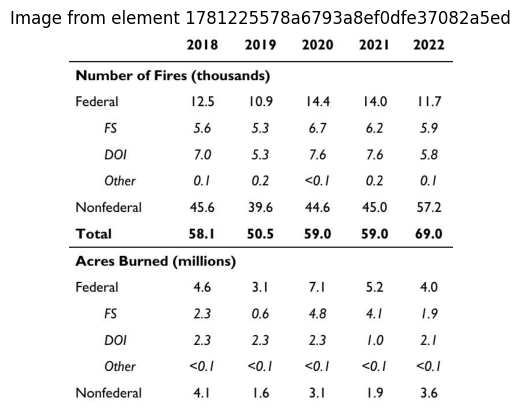

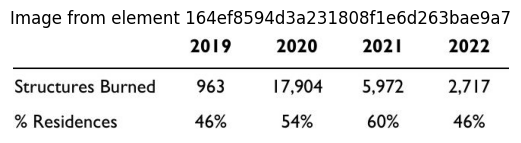

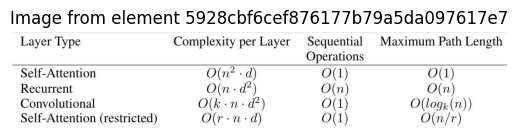

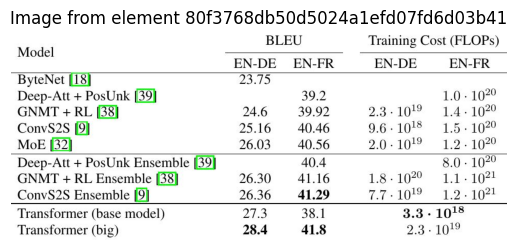

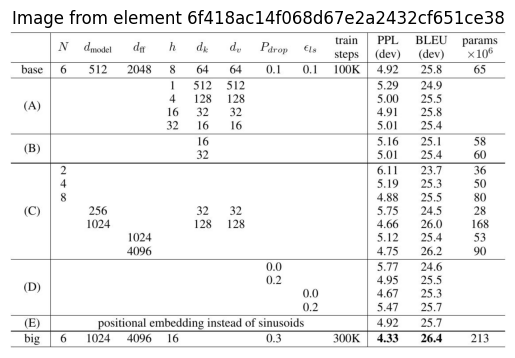

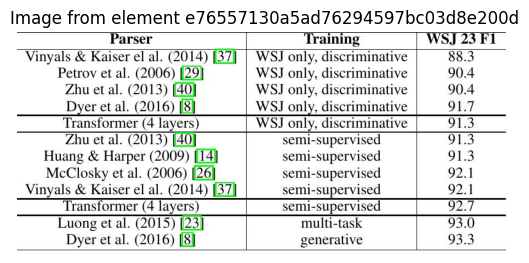

In [39]:
from PIL import Image
from io import BytesIO
import base64
from IPython.display import display
import matplotlib.pyplot as plt

def show_images_from_docs(docs):
    for idx, element in enumerate(docs):
        if element["type"] == "Table":
            b64_str = element['metadata'].get('image_base64')
            if b64_str:
                # Decode the base64 string into bytes
                image_data = base64.b64decode(b64_str)
                # Open the image with Pillow
                image = Image.open(BytesIO(image_data))
                
                # Display the image using matplotlib
                plt.imshow(image)
                plt.axis('off')  # Hide axis
                plt.title(f"Image from element {element['element_id']}")
                plt.show()
            else:
                print("No image data found in the element.")


show_images_from_docs(docs)

In [42]:
import htmltabletomd
md = htmltabletomd.convert_table(tables[0]["metadata"]["text_as_html"])
md

'|  | 2018 | 2019 | 2020 | 2021 | 2022 |\n| :--- | :--- | :--- | :--- | :--- | :--- |\n| Number of Fires (thousands) |\n| Federal | 12.5 | 10.9 | 144 | 14.0 | 1.7 |\n| FS | 5.6 | 53 | 6.7 | 6.2 | 59 |\n| DOl | 7.0 | 53 | 7.6 | 7.6 | 58 |\n| Other | 0.1 | 0.2 | &lt;0.1 | 0.2 | 0.1 |\n| Nonfederal | 45 | 39.6 | 44.6 | 45.0 | 57.2 |\n| Total | 58.1 | 50.5 | 59.0 | 59.0 | 69.0 |\n| Acres Burned (millions) |\n| Federal | 4.6 | 3.0 | 7.1 | 52 | 4.0 |\n| FS | 23 | 0.6 | 4.8 | 4.1 | 1.9 |\n| DOl | 23 | 23 | 23 | 1.0 | 2.1 |\n| Other | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 | &lt;0.1 |\n| Nonfederal | 4.1 | 1.6 | 3.1 | 1.9 | 3.6 |\n'

In [43]:
tables[0]["metadata"]["text_as_html"]

'<table><thead><tr><th></th><th>2018</th><th>2019</th><th>2020</th><th>2021</th><th>2022</th></tr></thead><tbody><tr><td colspan="6">Number of Fires (thousands)</td></tr><tr><td>Federal</td><td>12.5</td><td>10.9</td><td>144</td><td>14.0</td><td>1.7</td></tr><tr><td>FS</td><td>5.6</td><td>53</td><td>6.7</td><td>6.2</td><td>59</td></tr><tr><td>DOl</td><td>7.0</td><td>53</td><td>7.6</td><td>7.6</td><td>58</td></tr><tr><td>Other</td><td>0.1</td><td>0.2</td><td>&lt;0.1</td><td>0.2</td><td>0.1</td></tr><tr><td>Nonfederal</td><td>45</td><td>39.6</td><td>44.6</td><td>45.0</td><td>57.2</td></tr><tr><td>Total</td><td>58.1</td><td>50.5</td><td>59.0</td><td>59.0</td><td>69.0</td></tr><tr><td colspan="6">Acres Burned (millions)</td></tr><tr><td>Federal</td><td>4.6</td><td>3.0</td><td>7.1</td><td>52</td><td>4.0</td></tr><tr><td>FS</td><td>23</td><td>0.6</td><td>4.8</td><td>4.1</td><td>1.9</td></tr><tr><td>DOl</td><td>23</td><td>23</td><td>23</td><td>1.0</td><td>2.1</td></tr><tr><td>Other</td><td>&lt

In [62]:
import os
import tempfile

from fastapi import UploadFile
from fastapi.responses import JSONResponse
from marker.config.parser import ConfigParser
from marker.converters.pdf import PdfConverter
from marker.models import create_model_dict
from marker.output import text_from_rendered
from starlette import status


class FileConversionService:
    def __init__(self, output_format="markdown") -> None:
        self.config = {
            "output_format": output_format,
            "languages": "en",
            "disable_image_extraction": True,
            "workers": 6,
            "force_ocr" : False,
            
        }

        self.config_parser = ConfigParser(self.config)

        self.converter = PdfConverter(
            artifact_dict=create_model_dict(),
            config=self.config_parser.generate_config_dict(),
        )
        

    async def convert_to_markdown(self, file_bytes: UploadFile):
        try:
            # ✅ Use in-memory file instead of saving to disk
            with tempfile.NamedTemporaryFile(
                delete=False, mode="wb", suffix=".pdf"
            ) as temp_pdf:
                # Write the bytes to the temporary file
                temp_pdf.write(await file_bytes.read())
                temp_pdf_path = temp_pdf.name  # Get the path of the temporary file

            # Now that we have a file path, pass it to the converter
            rendered = self.converter(temp_pdf_path)

            text, metadata, images = text_from_rendered(rendered)

            # Optionally, delete the temp file after conversion
            os.remove(temp_pdf_path)

            return text
        
        except Exception as e:
            raise JSONResponse(
                content={"detail": f"Error during PDF conversion: {str(e)}"},
                status_code=status.HTTP_500_INTERNAL_SERVER_ERROR,
            ) 
            
    async def convert_to_text(self, file_bytes : UploadFile):
        try:
            # Read file content
            content = await file_bytes.read()
            text = content.decode("utf-8")
            return text
        except Exception as e:  
            print(e)

/Users/krishgoyani/Developer/Data Ingestion and RAG/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [65]:
import os
import asyncio
from fastapi import UploadFile

async def process_pdf_to_markdown():
    # Initialize the service
    conversion_service = FileConversionService()
    
    # Path to the PDF file in the "data" directory
    data_dir = "data"
    pdf_file_path = os.path.join(data_dir, "file.pdf")
    
    # Read the file and create an UploadFile object
    with open(pdf_file_path, "rb") as file:
        file_content = file.read()
    
    # Create an UploadFile object
    upload_file = UploadFile(
        filename="example.pdf",
        file=open(pdf_file_path, "rb")
    )
    
    # Call the convert_to_markdown method
    markdown_text = await conversion_service.convert_to_markdown(upload_file)
    
    # Print or save the result
    print(markdown_text)
    
    # Optionally save the markdown to a file
    output_path = os.path.join(data_dir, "example_converted.md")
    with open(output_path, "w", encoding="utf-8") as output_file:
        output_file.write(markdown_text)
    
    print(f"Markdown conversion completed. Output saved to {output_path}")

# Run the function
if __name__ == "__main__":
    asyncio.run(process_pdf_to_markdown())

Loaded layout model datalab-to/surya_layout on device mps with dtype torch.float16
Loaded texify model datalab-to/texify on device mps with dtype torch.float16
Loaded recognition model vikp/surya_rec2 on device mps with dtype torch.float16
Loaded table recognition model datalab-to/surya_tablerec on device mps with dtype torch.float16
Loaded detection model vikp/surya_det3 on device mps with dtype torch.float16
Loaded detection model datalab-to/inline_math_det0 on device mps with dtype torch.float16


Running OCR Error Detection: 100%|██████████| 4/4 [00:00<00:00,  8.25it/s]
Detecting bboxes: 0it [00:00, ?it/s]
Texify inference: 100%|██████████| 1/1 [00:05<00:00,  5.22s/it]
Detecting bboxes: 0it [00:00, ?it/s]
Recognizing tables: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.

# Attention Is All You Need

Ashish Vaswani∗ Google Brain avaswani@google.com

Llion Jones∗ Google Research llion@google.com

Noam Shazeer∗ Google Brain noam@google.com

Aidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu

Niki Parmar∗ Google Research nikip@google.com

Jakob Uszkoreit∗ Google Research usz@google.com

Łukasz Kaiser∗ Google Brain lukaszkaiser@google.com

Illia Polosukhin∗ ‡ illia.polosukhin@gmail.com

### Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convoluti

In [ ]:
try:
        
            queries, references, document_text = self.get_questions_answers_and_text(document_indices=[0,2])
            
            #text =  await self.file_conversion_service.convert_to_text(file_bytes)
            chunks =  self.text_splitter.recursive_text_splitter(document_text, chunk_size, chunk_overlap)
            
            embedding_tokens = await self.vector_db_service.pinecone_generate_and_store_embeddings(chunks)
            time.sleep(15)
            #self.cost_tracker.add_embedding_tokens(embedding_tokens)
            sparse_embeddings = self.sprase_embedding_service.generate_sparse_embeddings(chunks)
            await self.vector_db_service.pinecone_store_sparse_embeddings(chunks, sparse_embeddings)
            time.sleep(15)
            
            responses = []
            relevant_doc = []
            for query in queries:
                dense_chunks, embedding_tokens, read_units = await self.retrieve_chunks_service.pinecone_retrieve_similar_chunks(query, 10)
                #self.cost_tracker.add_read_units(read_units)
                #self.cost_tracker.add_embedding_tokens(embedding_tokens)
                sparse_chunks, read_units = await self.retrieve_chunks_service.pinecone_retrieve_similar_chunks_s(query, 10)
                #self.cost_tracker.add_read_units(read_units)
                
                sorted_items, sorted_documents = self.rrf_service.fuse(dense_chunks, sparse_chunks)
                final_chunks = await self.re_ranking_service.re_ranker(query, sorted_documents)
                #self.cost_tracker.add_rerank_units(rerank_units)
                
                
                response, llm_usage  = await self.llm_response_service.generate_response(final_chunks, query)
                responses.append(response)
                relevant_doc.append(final_chunks)
                #self.cost_tracker.add_llm_tokens(llm_usage)
                
            self.ragas_tesing.testing_loop(queries, relevant_doc , responses, references)
            
            #dense_embeddings,embedding_tokens  = await self.embedding_service.generate_embeddings(chunks)
            #self.cost_tracker.add_embedding_tokens(embedding_tokens)

            #await self.vector_db_service.qdrant_store_embeddings(embeddings)
            #await self.vector_db_service.milvus_store_embeddings(embeddings)
            #qdrant_chunks = await self.retrieve_chunks_service.search_qdrant(query, 20)
            #milvus_chunks = await self.retrieve_chunks_service.search_milvus(query, 10)
                    
            #await self.cost_storage_repo.store_cost_details(self.cost_tracker.to_dict())
            self.delete_index.delete_all_index()
            return 'final_chunks', 'pinecone_chunks', 'sparse_chunks', chunks
        except Exception as e:
            print(e)
        
            